# Differences in RNA stability - TimeLapse-seq

In [1]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sciF
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")

params = {'mathtext.default': 'it' } 
plt.rcParams.update(params)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]

TimeLapse-seq data was analyzed using the R-based BakR pipeline. Results dataframes were exported for plots and correlative analysis here. The data was processed 2 ways: (1) with EV as the reference condition, (2) with 4SD as the reference condition. 

In [3]:
#Set datapath for TimeLapse analyses
path = "path/to/bakr/data/"

path_2 = "/path/to/data/"

In [4]:
figpath = "./"

In [5]:
#Data for EV vs all condtions with EV as reference condition
BakR_effects_df_all = pd.read_csv(path + "12142023_Fit_effects_DF_all.csv", sep = " ").dropna()
BakR_effects_df_all["gene_id"] = BakR_effects_df_all.XF.str.split(".").str[0]
BakR_effects_df_all["gene_id"] = BakR_effects_df_all.XF.str.split(".").str[0]

BakR_Reg_estimates_all = pd.read_csv(path + "12142023_Fit_Regularized_ests_all.csv", sep = " ").dropna()
BakR_Reg_estimates_all["gene_id"] = BakR_Reg_estimates_all.XF.str.split(".").str[0]
BakR_Reg_estimates_all["gene_id"] = BakR_Reg_estimates_all.XF.str.split(".").str[0]

BakR_Fn_estimates_all = pd.read_csv(path + "12142023_Fit_Fn_Estimates_all.csv", sep = " ").dropna()
BakR_Fn_estimates_all["gene_id"] = BakR_Fn_estimates_all.XF.str.split(".").str[0]
BakR_Fn_estimates_all["gene_id"] = BakR_Fn_estimates_all.XF.str.split(".").str[0]


gene_types = pd.read_csv(path_2 + "config/gene_types_df.tsv", sep = "\t")
BakR_effects_df_all = gene_types.merge(BakR_effects_df_all, on = "gene_id")

#Assign sample information for kdeg estimates
BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Exp_ID == 1, "Sample"] = "EV"
BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Exp_ID == 2, "Sample"] = "WT"
BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Exp_ID == 3, "Sample"] = "4SA"
BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Exp_ID == 4, "Sample"] = "4SD"

In [6]:
#Data for 4SA vs 4SD with 4SD as reference condition
BakR_effects_df = pd.read_csv(path + "12142023_Fit_effects_DF_4SA_4SD.csv", sep = " ").dropna()
BakR_effects_df["gene_id"] = BakR_effects_df.XF.str.split(".").str[0]
BakR_effects_df["gene_id"] = BakR_effects_df.XF.str.split(".").str[0]

BakR_Reg_estimates = pd.read_csv(path + "12142023_Fit_Regularized_ests_4SA_4SD.csv", sep = " ").dropna()
BakR_Reg_estimates["gene_id"] = BakR_Reg_estimates.XF.str.split(".").str[0]
BakR_Reg_estimates["gene_id"] = BakR_Reg_estimates.XF.str.split(".").str[0]

BakR_Fn_estimates = pd.read_csv(path + "12142023_Fit_Fn_Estimates_4SA_4SD.csv", sep = " ").dropna()
BakR_Fn_estimates["gene_id"] = BakR_Fn_estimates.XF.str.split(".").str[0]
BakR_Fn_estimates["gene_id"] = BakR_Fn_estimates.XF.str.split(".").str[0]

gene_types = pd.read_csv(path_2 + "config/gene_types_df.tsv", sep = "\t")
BakR_effects_df = gene_types.merge(BakR_effects_df, on = "gene_id")

RNA half lives can be calculated from kdeg estimates as follows: HL = ln(2)/kdeg

In [7]:
#Caclulate RNA half lives
BakR_Fn_estimates_all["halflife"] = np.log(2)/BakR_Fn_estimates_all["kdeg"]
# BakR_Fn_estimates["halflife"] = np.log2(1/BakR_Fn_estimates["kdeg"])

Now take a look at general stability (Half-lives) of transcripts in each condition

In [9]:
#Define a function to caclulate cumulative distribution function
def cumsum(data):
    # sort the data in ascending order
    x = np.sort(data)

    # get the cdf values of y
    y = np.arange(len(data)) / float(len(data))
    return(x, y)

In [19]:
BakR_Fn_estimates_all

,Feature_ID,Exp_ID,Replicate,logit_fn,logit_fn_se,nreads,log_kdeg,kdeg,log_kd_se,sample,XF,gene_id,Sample,halflife
0,1,1,1,0.677296,0.170749,170,-4.703084,0.009067,0.104064,EV_1,Amp_R,Amp_R,EV,76.444935
1,1,1,2,0.545615,0.155205,185,-4.784781,0.008356,0.097997,EV_2,Amp_R,Amp_R,EV,82.952513
2,1,1,3,0.316410,0.190225,121,-4.933888,0.007198,0.127383,EV_3,Amp_R,Amp_R,EV,96.291062
3,1,2,1,0.064617,0.271106,60,-5.107728,0.006050,0.192748,WT_1,Amp_R,Amp_R,WT,114.573343
4,1,2,2,0.028674,0.240866,75,-5.133386,0.005897,0.172642,WT_2,Amp_R,Amp_R,WT,117.551135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133579,11132,3,2,-0.078105,0.052722,1536,-5.210830,0.005457,0.038683,4SA_2,HygR,HygR,4SA,127.016510
133580,11132,3,3,-0.065628,0.063969,1033,-5.201688,0.005507,0.046810,4SA_3,HygR,HygR,4SA,125.860571
133581,11132,4,1,-0.023396,0.062474,1096,-5.170925,0.005679,0.045298,4SD_1,HygR,HygR,4SD,122.047684
133582,11132,4,2,0.098326,0.056058,1379,-5.083854,0.006196,0.039550,4SD_2,HygR,HygR,4SD,111.870404


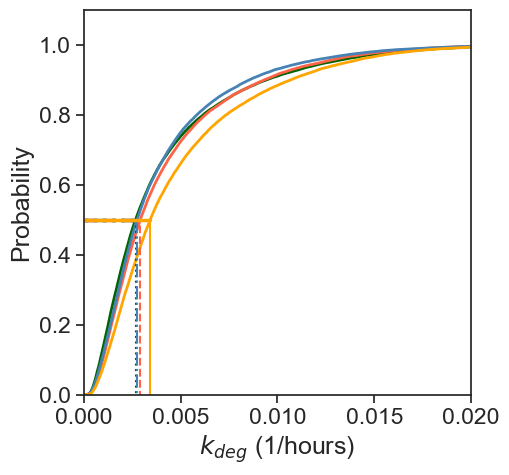

In [22]:
#Plot CDF for HL of each sample
x1, y1 = cumsum(BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "EV"].kdeg)
x2, y2 = cumsum(BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "WT"].kdeg)
x3, y3 = cumsum(BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "4SA"].kdeg)
x4, y4 = cumsum(BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "4SD"].kdeg)

# x1, y1 = cumsum(np.log2(BakR_Fn_estimates.loc[BakR_Fn_estimates.Exp_ID == 2].kdeg), 100)
# x2, y2 = cumsum(np.log2(BakR_Fn_estimates.loc[BakR_Fn_estimates.Exp_ID == 1].kdeg), 100)

# plot the cumulative function
f, ax = plt.subplots(1,1, figsize = (5,5))
sns.lineplot(x = (x1), y = y1, color = four_palette[0], linewidth = 2)
sns.lineplot(x = (x2), y = y2, color = four_palette[1], linewidth = 2)
sns.lineplot(x = (x3), y = y3, color = four_palette[2], linewidth = 2)
sns.lineplot(x = (x4), y = y4, color = four_palette[3], linewidth = 2)

ax.set_ylabel("Probability")
ax.set_xlabel("$k_{deg}$ (1/hours)")
ax.set_xlim(0, 0.02)
ax.set_ylim(0, 1.1)

sns.lineplot(x = [0,np.median(x1)], y = [0.5, 0.5], color = four_palette[0], linestyle = "dotted", linewidth = 2.5)
ax.axvline(x = np.median(x1), ymin = -1, ymax = 0.45, color = four_palette[0], linestyle = "dotted", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x2)], y = [0.5, 0.5], color = four_palette[1], linestyle = "dashed", linewidth = 2.5)
ax.axvline(x = np.median(x2), ymin = -1, ymax = 0.45, color = four_palette[1], linestyle = "dashed", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x3)], y = [0.5, 0.5], color = four_palette[2], linestyle = "dashdot", linewidth = 2.5)
ax.axvline(x = np.median(x3), ymin = -1, ymax = 0.45, color = four_palette[2], linestyle = "dashdot", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x4)], y = [0.5, 0.5], color = four_palette[3], linestyle = "-", linewidth = 2.5)
ax.axvline(x = np.median(x4), ymin = -1, ymax = 0.45, color = four_palette[3], linestyle = "-", linewidth = 1.5)

plt.savefig(figpath + 'kdeg_CDF.png', dpi=300, bbox_inches="tight")

In [11]:
print(np.median(x1), 
     np.median(x2), 
     np.median(x3), 
     np.median(x4))

0.002678044178373 0.0029244737574084002 0.00276036237786715 0.0034407967011399502


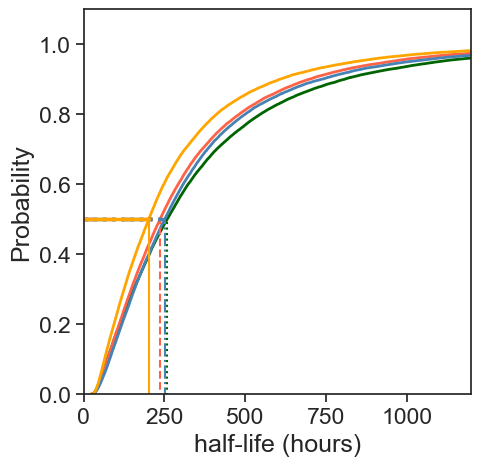

In [14]:
#Plot CDF for HL of each sample
x1, y1 = cumsum(np.log(2)/BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "EV"].kdeg)
x2, y2 = cumsum(np.log(2)/BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "WT"].kdeg)
x3, y3 = cumsum(np.log(2)/BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "4SA"].kdeg)
x4, y4 = cumsum(np.log(2)/BakR_Fn_estimates_all.loc[BakR_Fn_estimates_all.Sample == "4SD"].kdeg)
# x1, y1 = cumsum(np.log2(BakR_Fn_estimates.loc[BakR_Fn_estimates.Exp_ID == 2].kdeg), 100)
# x2, y2 = cumsum(np.log2(BakR_Fn_estimates.loc[BakR_Fn_estimates.Exp_ID == 1].kdeg), 100)

# plot the cumulative function
f, ax = plt.subplots(1,1, figsize = (5,5))
sns.lineplot(x = (x1), y = y1, color = four_palette[0], linewidth = 2)
sns.lineplot(x = (x2), y = y2, color = four_palette[1], linewidth = 2)
sns.lineplot(x = (x3), y = y3, color = four_palette[2], linewidth = 2)
sns.lineplot(x = (x4), y = y4, color = four_palette[3], linewidth = 2)

ax.set_ylabel("Probability")
ax.set_xlabel("half-life (hours)")
ax.set_xlim(0, 1200)
ax.set_ylim(0, 1.1)

sns.lineplot(x = [0,np.median(x1)], y = [0.5, 0.5], color = four_palette[0], linestyle = "dotted", linewidth = 2.5)
ax.axvline(x = np.median(x1), ymin = -1, ymax = 0.45, color = four_palette[0], linestyle = "dotted", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x2)], y = [0.5, 0.5], color = four_palette[1], linestyle = "dashed", linewidth = 2.5)
ax.axvline(x = np.median(x2), ymin = -1, ymax = 0.45, color = four_palette[1], linestyle = "dashed", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x3)], y = [0.5, 0.5], color = four_palette[2], linestyle = "dashdot", linewidth = 2.5)
ax.axvline(x = np.median(x3), ymin = -1, ymax = 0.45, color = four_palette[2], linestyle = "dashdot", linewidth = 1.5)

sns.lineplot(x = [0,np.median(x4)], y = [0.5, 0.5], color = four_palette[3], linestyle = "-", linewidth = 2.5)
ax.axvline(x = np.median(x4), ymin = -1, ymax = 0.45, color = four_palette[3], linestyle = "-", linewidth = 1.5)

plt.savefig(figpath + 'Half_life_CDF.png', dpi=300, bbox_inches="tight")

In [18]:
#Print median half lives for comparison
print(np.median(x1), 
     np.median(x2), 
     np.median(x3), 
     np.median(x4))

258.8258947187445 237.016038777878 251.10731412995563 201.44961788719934


This looks like RNA is 4SD is less stable than 4SA. Run statistical testing to make sure.

In [17]:
#Define pairs to compare
pairs = [["EV", "WT"],
         ["EV", "4SA"],
         ["WT", "4SA"],
         ["WT", "4SD"],
         ["4SA", "4SD"],
         ["EV", "4SD"]
        ]

#Loop through pairs list and print out pvalues (two-tailed t-test)
for pair in pairs:
    c1 = pair[0]
    c2 = pair[1]
    group_df = BakR_Fn_estimates_all.groupby(["Sample", "Replicate"]).median()
    c1_data = list(np.log(2)/group_df.loc[c1].kdeg)
    c2_data = list(np.log(2)/group_df.loc[c2].kdeg)
    stat = stats.ttest_ind(c1_data, c2_data).pvalue
    print(str(pair) + ": " + str(stat))

['EV', 'WT']: 0.36199532121638545
['EV', '4SA']: 0.680790573841237
['WT', '4SA']: 0.2620061292317838
['WT', '4SD']: 0.030357991859930746
['4SA', '4SD']: 0.0014966576996552306
['EV', '4SD']: 0.049814443703530324


/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_13532/3073242688.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = BakR_Fn_estimates_all.groupby(["Sample", "Replicate"]).median()
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_13532/3073242688.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_df = BakR_Fn_estimates_all.groupby(["Sample", "Replicate"]).median()
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_13532/3073242688.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric

Take a look at any genes that have significantly different stability (4SA vs 4SD)

In [14]:
#Write a function to make volcano plots in this notebook
def bakR_makeVolcano(data, FDR, ID1):
    f, ax = plt.subplots(1, 1, figsize = (5, 5))
    sns.scatterplot(data = data.loc[data.Exp_ID == ID1], x = "L2FC_kdeg", y = -np.log10(data.padj), color = "lightgray", s = 20, edgecolor = "black", linewidth = 0.15)
    sns.scatterplot(data = data.loc[(data.Exp_ID == ID1) & (data.padj < FDR) & (data.L2FC_kdeg > 0)], x = "L2FC_kdeg", y = -np.log10(data.padj), s = 20, color = "orange", edgecolor = "black", linewidth = 0.15)
    sns.scatterplot(data = data.loc[(data.Exp_ID == ID1) & (data.padj < FDR) & (data.L2FC_kdeg < 0)], x = "L2FC_kdeg", y = -np.log10(data.padj), s = 20, color = "steelblue", edgecolor = "black", linewidth = 0.15)

    ax.axhline(-np.log10(FDR), linestyle = "--", color = "black")
    ax.set_xlabel("$log_{2}$($k_{deg:4SA}$/$k_{deg:4SD}$)")
    ax.set_ylabel("-$log_{10}$($p_{adj}$)")
    ax.set_xlim(-2, 2)
    ax.set_ylim(0,4)

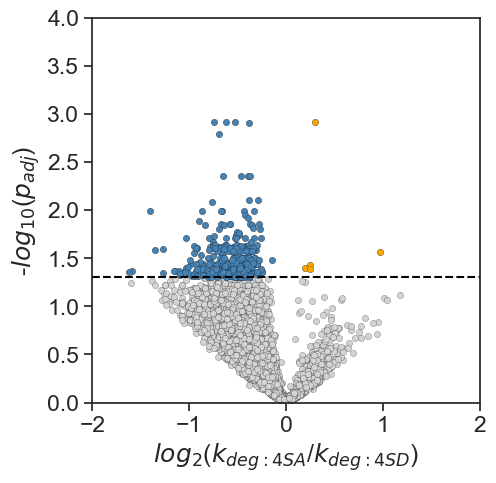

In [15]:
bakR_makeVolcano(BakR_effects_df, 0.05, 2)
# plt.savefig(figpath + 'TL_kdeg_4SAv4SD.png', dpi=300, bbox_inches="tight")

In [47]:
stabilized = list(BakR_effects_df.loc[(BakR_effects_df.padj < 0.05) & (BakR_effects_df.L2FC_kdeg < 0) & (BakR_effects_df.Exp_ID == 2)].gene_name)
# BakR_effects_df.loc[(BakR_effects_df.padj < 0.05) & (BakR_effects_df.L2FC_kdeg < 0) & (BakR_effects_df.Exp_ID == 2)]


In [49]:
len(stabilized)

387

In [22]:
CC_list = list(pd.read_csv("Krenning_220_genes_downreg.txt", header = None)[0])

In [24]:
overlap_df = []
for i in destabilized:
    if i in CC_list:
        overlap_df.append(i)
overlap_df
    

['KIF2C',
 'USP1',
 'CEP350',
 'CENPF',
 'ANLN',
 'RAD21',
 'CKAP5',
 'KIF23',
 'TOP2A',
 'KPNA2']

In [17]:
file = open('4SA_stabilized_genes.txt','w')
for x in BakR_effects_df.loc[(BakR_effects_df["L2FC_kdeg"] < 0) & (BakR_effects_df["padj"] < 0.05) & (BakR_effects_df.Exp_ID == 2)].gene_name:
    file.write(x +"\n")
file.close()

file = open('4SD_stabilized_genes.txt','w')
for x in BakR_effects_df.loc[(BakR_effects_df["L2FC_kdeg"] > 0) & (BakR_effects_df["padj"] < 0.05) & (BakR_effects_df.Exp_ID == 2)].gene_name:
    file.write(x +"\n")
file.close()

file = open('4SA_4SD_all_genes.txt','w')
for x in BakR_effects_df.gene_name:
    file.write(x +"\n")
file.close()

In [18]:
len(BakR_effects_df)

11130

In [19]:
len(BakR_effects_df.loc[(BakR_effects_df["L2FC_kdeg"] < 0) & (BakR_effects_df["padj"] < 0.05) & (BakR_effects_df.Exp_ID == 2)].gene_name)

387

In [20]:
destabilized_genes = BakR_effects_df.loc[(BakR_effects_df.Exp_ID == 2) & (BakR_effects_df.padj < 0.05) & (BakR_effects_df.L2FC_kdeg < 0)]
destabilized_genes.head(3)

,biotype,gene_id,gene_name,Feature_ID,Exp_ID,L2FC_kdeg,effect,se,pval,padj,XF
35,protein_coding,ENSG00000078369,GNB1,1010,2,-0.461428,-0.319838,0.068958,0.000410,0.032757,ENSG00000078369.19
73,protein_coding,ENSG00000074800,ENO1,901,2,-0.253732,-0.175874,0.042877,0.001134,0.043655,ENSG00000074800.16
86,protein_coding,ENSG00000054523,KIF1B,494,2,-0.432848,-0.300028,0.072006,0.001001,0.042926,ENSG00000054523.20


In [21]:
BakR_effects_df_all.loc[(BakR_effects_df_all.Exp_ID == 4) & (BakR_effects_df_all.padj < 0.05) & (BakR_effects_df_all.L2FC_kdeg > 0)]

,biotype,gene_id,gene_name,Feature_ID,Exp_ID,L2FC_kdeg,effect,se,pval,padj,XF
806,protein_coding,ENSG00000162521,RBBP4,6820,4,0.990359,0.686464,0.113377,3.031638e-05,0.024694,ENSG00000162521.19
1430,protein_coding,ENSG00000116754,SRSF11,3138,4,0.631168,0.437493,0.080570,9.037071e-05,0.035638,ENSG00000116754.14
1937,protein_coding,ENSG00000266338,NBPF15,10762,4,1.197018,0.829710,0.160073,1.411492e-04,0.044408,ENSG00000266338.7
2324,protein_coding,ENSG00000198952,SMG5,9869,4,0.829927,0.575262,0.105262,8.487485e-05,0.035405,ENSG00000198952.8
2357,protein_coding,ENSG00000143321,HDGF,5436,4,0.779845,0.540547,0.088535,2.780629e-05,0.024105,ENSG00000143321.19
...,...,...,...,...,...,...,...,...,...,...,...
31586,protein_coding,ENSG00000130844,ZNF331,4181,4,1.274929,0.883713,0.149754,3.945757e-05,0.026107,ENSG00000130844.19
31616,protein_coding,ENSG00000167615,LENG8,7549,4,1.374228,0.952542,0.098414,1.462786e-07,0.000977,ENSG00000167615.17
32585,protein_coding,ENSG00000184164,CRELD2,8995,4,1.767538,1.225164,0.219642,6.942372e-05,0.032201,ENSG00000184164.15
32600,protein_coding,ENSG00000128159,TUBGCP6,3956,4,1.047743,0.726240,0.128964,6.317631e-05,0.031994,ENSG00000128159.12


Do changes in stability lead to any observed alterations in gene expression?

In [22]:
#Load DE_df dataframe
DE_df = pd.read_csv(path + "12042023_DE_df_4SA_4SD.csv", sep = " ")
DE_df["gene_id"] = DE_df["XF"].str.split(".").str[0]
DE_df = DE_df.merge(gene_types, on = "gene_id")
DE_df.head()

,XF,L2FC_RNA,DE_score,DE_se,DE_pval,DE_padj,conclusion,gene_id,biotype,gene_name
0,ENSG00000000003.15,0.177920,0.950746,0.187137,0.341733,0.713936,Not sig.,ENSG00000000003,protein_coding,TSPAN6
1,ENSG00000000419.14,-0.068953,-0.518448,0.133000,0.604146,0.854768,Not sig.,ENSG00000000419,protein_coding,DPM1
2,ENSG00000000457.14,-0.177691,-0.669066,0.265581,0.503453,0.809869,Not sig.,ENSG00000000457,protein_coding,SCYL3
3,ENSG00000000460.17,0.408551,2.067572,0.197600,0.038680,0.340726,Not sig.,ENSG00000000460,protein_coding,C1orf112
4,ENSG00000001036.14,0.220622,1.798232,0.122688,0.072140,0.426349,Not sig.,ENSG00000001036,protein_coding,FUCA2


In [23]:
DE_df.loc[(DE_df.L2FC_RNA < 1) & (DE_df.DE_padj < 0.05)].head()

,XF,L2FC_RNA,DE_score,DE_se,DE_pval,DE_padj,conclusion,gene_id,biotype,gene_name
85,ENSG00000006283.18,-0.635959,-3.621303,0.175616,0.000293,0.029237,Not sig.,ENSG00000006283,protein_coding,CACNA1G
134,ENSG00000008300.17,-0.604684,-3.887523,0.155545,0.000101,0.013282,Not sig.,ENSG00000008300,protein_coding,CELSR3
176,ENSG00000011028.14,-0.697728,-4.571825,0.152615,0.000005,0.002180,Decreased txn,ENSG00000011028,protein_coding,MRC2
203,ENSG00000012660.14,0.512120,4.270234,0.119928,0.000020,0.005438,Increased txn,ENSG00000012660,protein_coding,ELOVL5
283,ENSG00000024526.17,0.477742,3.633844,0.131470,0.000279,0.028551,Not sig.,ENSG00000024526,protein_coding,DEPDC1


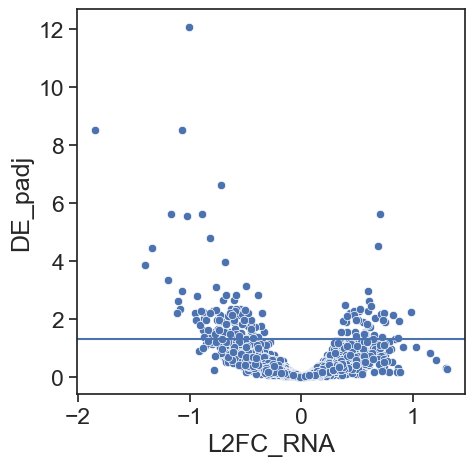

In [24]:
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = DE_df, x = "L2FC_RNA", y = -np.log10(DE_df["DE_padj"]))

ax.axhline(-np.log10(0.05))

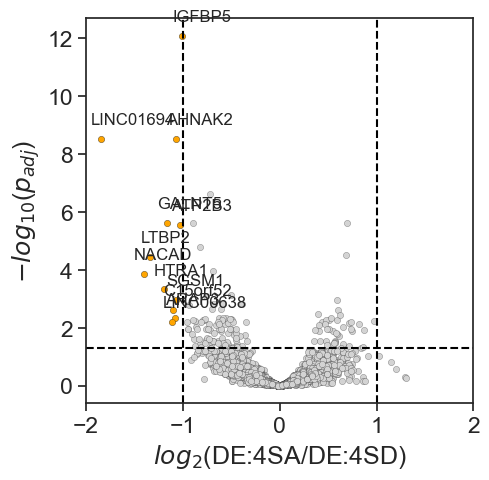

In [25]:
#WT vs 4SA
Annotate = True

f, ax = plt.subplots(1,1, figsize = (5,5))
upreg = DE_df.loc[(DE_df["L2FC_RNA"] >= 1) & (DE_df["DE_padj"] <= 0.05)]
downreg = DE_df.loc[(DE_df["L2FC_RNA"] <= -1) & (DE_df["DE_padj"] <= 0.05)]

sns.scatterplot(data = DE_df, x = "L2FC_RNA", y = -np.log10(DE_df["DE_padj"]), s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = upreg, x = "L2FC_RNA", y = -np.log10(upreg["DE_padj"]), s = 20, alpha = 1, color = "steelblue", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = downreg, x = "L2FC_RNA", y = -np.log10(downreg["DE_padj"]), s = 20, alpha = 1, color = "orange", edgecolor = "black", linewidth = 0.15)

ax.axvline(-1, color = "black", linestyle = "--")
ax.axvline(1, color = "black", linestyle = "--")
ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")

ax.set_xlim(-2, 2)
ax.set_xlabel("$log_{2}$(DE:4SA/DE:4SD)")
ax.set_ylabel("$-log_{10}$($p_{adj}$)")

#Annotations
if Annotate == True:
    for i in upreg.index: 
        plt.annotate(upreg["gene_name"][i], ((upreg["L2FC_RNA"][i]), (-np.log10(upreg["DE_padj"][i]) + 0.2)), fontsize = 12) 

    for i in downreg.index: 
        plt.annotate(downreg["gene_name"][i], ((downreg["L2FC_RNA"][i] - 0.1), (-np.log10(downreg["DE_padj"][i]) + 0.5)), fontsize = 12) 
        
# plt.savefig(figpath + 'RNA_levels_TL.png', dpi=300, bbox_inches="tight")

Load in the ksyn dataframe (also estimated using bakR) to look at differences in synthesis rates between 4SA and 4SD.

In [26]:
ksyn_df = pd.read_csv(path + "12042023_ksyn_df_4SA_4SD.csv", sep = " ")
ksyn_df["XF"] = ksyn_df["Gene"]
ksyn_df.head()

,L2FC,Gene,se,pval,padj,conclusion,XF
0,-0.074121,Amp_R,0.440186,0.866280,0.931754,Not sig.,Amp_R
1,-0.214035,ENSG00000000003.15,0.271848,0.431087,0.653620,Not sig.,ENSG00000000003.15
2,-0.475191,ENSG00000000419.14,0.281602,0.091515,0.276903,Not sig.,ENSG00000000419.14
3,-0.299957,ENSG00000000457.14,0.398998,0.452186,0.668426,Not sig.,ENSG00000000457.14
4,-0.063395,ENSG00000000460.17,0.330576,0.847922,0.921494,Not sig.,ENSG00000000460.17


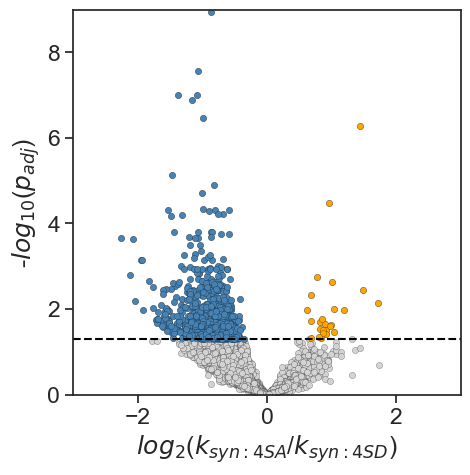

In [92]:
#WT vs 4SA
Annotate = False

f, ax = plt.subplots(1,1, figsize = (5,5))
upreg = ksyn_df.loc[(ksyn_df["L2FC"] >= 0) & (ksyn_df["padj"] <= 0.05)]
downreg = ksyn_df.loc[(ksyn_df["L2FC"] <= -0) & (ksyn_df["padj"] <= 0.05)]

sns.scatterplot(data = ksyn_df, x = "L2FC", y = -np.log10(ksyn_df["padj"]), s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = upreg, x = "L2FC", y = -np.log10(upreg["padj"]), s = 20, alpha = 1, color = "orange", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = downreg, x = "L2FC", y = -np.log10(downreg["padj"]), s = 20, alpha = 1, color = "steelblue", edgecolor = "black", linewidth = 0.15)

# ax.axvline(-1, color = "black", linestyle = "--")
# ax.axvline(1, color = "black", linestyle = "--")
ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")

ax.set_xlim(-3, 3)
ax.set_ylim(0, 9)
ax.set_xlabel("$log_{2}$($k_{syn:4SA}$/$k_{syn:4SD}$)")
ax.set_ylabel("-$log_{10}$($p_{adj}$)")

#Annotations
if Annotate == True:
    for i in upreg.index: 
        plt.annotate(upreg["gene_name"][i], ((upreg["L2FC"][i]), (-np.log10(upreg["padj"][i]) + 0.2)), fontsize = 12) 

    for i in downreg.index: 
        plt.annotate(downreg["gene_name"][i], ((downreg["L2FC"][i] - 0.1), (-np.log10(downreg["padj"][i]) + 0.5)), fontsize = 12) 
        
plt.savefig(figpath + 'TL_ksyn_4SAv4SD.png', dpi=300, bbox_inches="tight")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


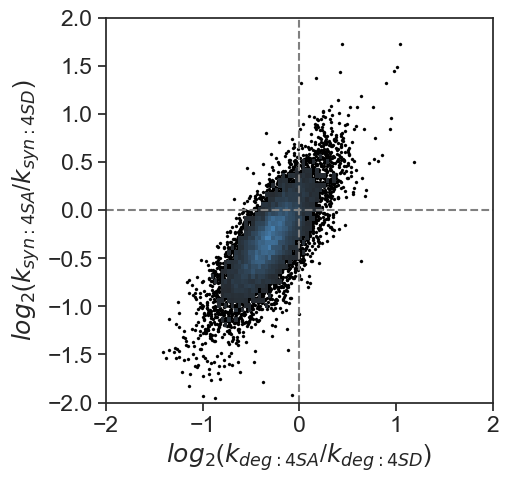

In [28]:
#Correlate ksyn to kdeg
colorway = sns.dark_palette("steelblue", reverse=False, as_cmap=True)

test_df = BakR_effects_df.merge(ksyn_df, on = "XF")
test_df.head()

x = test_df.L2FC_kdeg
y = test_df.L2FC
res = stats.linregress(x, y)

f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=x, y=y, s=5, color="black", edgecolor = "black")
sns.histplot(x=x, y=y, bins=80, pthresh=.1, cmap=colorway)

# sns.lineplot(x = x, y = res.intercept + res.slope*x, color = 'grey', linestyle = "--", linewidth = 2)

ax.axhline(0,0, color = "grey", linestyle = "--")
ax.axvline(0,0, color = "grey", linestyle = "--")
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel("$log_{2}$($k_{deg:4SA}$/$k_{deg:4SD}$)")
ax.set_ylabel("$log_{2}$($k_{syn:4SA}$/$k_{syn:4SD}$)")

plt.savefig(figpath + 'ksyn_v_kdeg_TL_4SAv4SD.png', dpi=300, bbox_inches="tight")

In [29]:
res

LinregressResult(slope=1.0966294244834032, intercept=0.023061287777880413, rvalue=0.7576313833518655, pvalue=0.0, stderr=0.008955616158104501, intercept_stderr=0.003472009542636611)

Now take a look at whether there is a relationship between poly(A) tail lengthing and RNA stability

In [32]:
#Function to read polyA tab del files AFTER running get_tails.py
def read_polyA_gene(file, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [33]:
#Read in dfs for gene tail metrics
per_gene_h112_1 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h112.R1_per_gene.tsv", "EV", "1")
per_gene_h112_2 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h112.R2_per_gene.tsv", "EV", "2")

per_gene_h113_1 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h113.R1_per_gene.tsv", "WT", "1")
per_gene_h113_2 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h113.R2_per_gene.tsv", "WT", "2")

per_gene_h115_1 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h115.R1_per_gene.tsv", "4SA", "1")
per_gene_h115_2 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h115.R2_per_gene.tsv", "4SA", "2")

per_gene_h117_1 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h117.R1_per_gene.tsv", "4SD", "1")
per_gene_h117_2 = read_polyA_gene(path_2 + "results/polyA_len/per_gene/h117.R2_per_gene.tsv", "4SD", "2")

#Concatenate samples and conditions into single dataframes
df_gene = pd.concat([per_gene_h112_1, per_gene_h112_2, per_gene_h113_1, per_gene_h113_2, per_gene_h115_1, per_gene_h115_2, per_gene_h117_1, per_gene_h117_2])

df_gene = df_gene.loc[df_gene['median'] >= 10]
df_gene.rename(columns={"Unnamed: 0":'gene_id'}, inplace=True)

df_gene.gene_id = df_gene.gene_id.str.split(".").str[0]
#Path to gene types df (from gtf)
gene_types = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
df_gene = df_gene.merge(gene_types, on = 'gene_id')

In [34]:
#Calculate median of each gene ID between replicates
df_median = df_gene.groupby(by = ['gene_id', 'Sample', 'biotype'], as_index = False).median()
BakR_Fn_estimates_all_mean = BakR_Fn_estimates_all.groupby(["Sample", "gene_id"], as_index = False).mean()
df_mean_bakR = df_median.merge(BakR_Fn_estimates_all_mean, on = ["gene_id", "Sample"])

/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_13532/2460974566.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_median = df_gene.groupby(by = ['gene_id', 'Sample', 'biotype'], as_index = False).median()
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_13532/2460974566.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  BakR_Fn_estimates_all_mean = BakR_Fn_estimates_all.groupby(["Sample", "gene_id"], as_index = False).mean()


In [35]:
#Group into tail length bins
df_mean_bakR.loc[(df_mean_bakR["median"] < 10), "tail_bin"] = "< 10"
df_mean_bakR.loc[(df_mean_bakR["median"] > 10) & (df_mean_bakR["median"] < 49), "tail_bin"] = "10 - 49"
df_mean_bakR.loc[(df_mean_bakR["median"] > 50) & (df_mean_bakR["median"] < 99), "tail_bin"] = "50 - 99"
df_mean_bakR.loc[(df_mean_bakR["median"] > 100) & (df_mean_bakR["median"] < 150), "tail_bin"] = "100 - 150"
df_mean_bakR.loc[(df_mean_bakR["median"] > 150), "tail_bin"] = ">150"

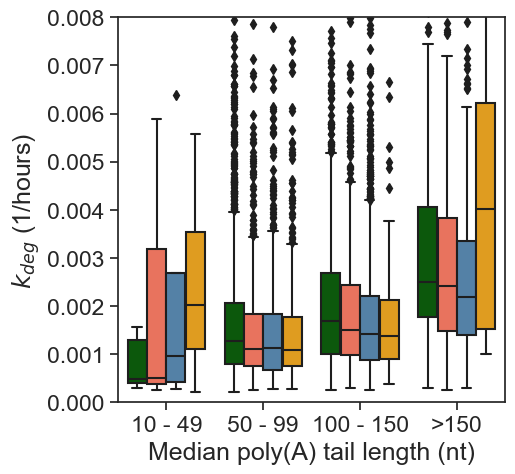

In [36]:
#Plot 
f, ax = plt.subplots(1,1, figsize = (5,5))

order = ['10 - 49', '50 - 99', '100 - 150', '>150']
hue_order = ["EV", "WT", "4SA", "4SD"]

sns.boxplot(data = df_mean_bakR, x = "tail_bin", y = "kdeg", order = order, hue = "Sample", hue_order = hue_order, palette = four_palette)
ax.set_xlabel("Median poly(A) tail length (nt)")
ax.set_ylabel("$k_{deg}$ (1/hours)")

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend([],[], frameon=False)
ax.set_ylim(0, 0.008)


plt.savefig(figpath + 'tail_length_bins_stability.png', dpi=300, bbox_inches="tight")

In [37]:
#Function to read polyA tab del files
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [38]:
#Read in dfs for all reads
min_A_count = 10

h112_1 = read_polyA_reads(path_2 + 'results/polyA_len/h112.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path_2 + 'results/polyA_len/h112.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path_2 + 'results/polyA_len/h113.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path_2 + 'results/polyA_len/h113.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path_2 + 'results/polyA_len/h115.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path_2 + 'results/polyA_len/h115.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path_2 + 'results/polyA_len/h117.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path_2 + 'results/polyA_len/h117.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path_2 + "config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)
all_reads["gene_id"] = all_reads["gene_id"].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

In [39]:
#Define a function to compare tail lengths per gene between two conditions
def compare_tail_lengths(df, c1, c2, min_reads=25):
    #select genes that are common between conditions
    c1_genes = df.loc[df.Sample == c1].gene_id
    common_genes = list(np.unique(df.loc[(df.Sample == c2) & df.gene_id.isin(c1_genes)].gene_id ))
    #calculate summary stats of each gene between conditions and test for statistical significance 
    per_gene_res_c1 = dict()
    per_gene_res_c2 = dict()
    reads_c1 = df.loc[df["Sample"] == c1]
    reads_c2 = df.loc[df["Sample"] == c2]
    for i in tqdm(np.unique(common_genes)):
        temp_c1 = reads_c1[reads_c1.gene_id == i]
        temp_c2 = reads_c2[reads_c2.gene_id == i]
        if (len(temp_c1) & len(temp_c2)) >= min_reads:
            per_gene_res_c1[i] = [np.mean(temp_c1.tail_len), np.median(temp_c1.tail_len), pearson_skew_2(temp_c1.tail_len), len(temp_c1.tail_len)]
            per_gene_res_c2[i] = [np.mean(temp_c2.tail_len), np.median(temp_c2.tail_len), pearson_skew_2(temp_c2.tail_len), len(temp_c2.tail_len), np.unique(temp_c1.gene_name)[0], stats.mannwhitneyu(temp_c1.tail_len, temp_c2.tail_len).pvalue]
    
    #build a dataframe for results output
    per_gene_c1 = pd.DataFrame.from_dict(per_gene_res_c1, orient='index', columns=[('mean' + "_" + c1), 'median'+ "_" + c1, 'skew'+ "_" + c1, 'n'+ "_" + c1])
    per_gene_c2 = pd.DataFrame.from_dict(per_gene_res_c2, orient='index', columns=[('mean' + "_" + c2), 'median'+ "_" + c2, 'skew'+ "_" + c2, 'n'+ "_" + c2, "gene_name", "pvalue"])
    per_gene_df = per_gene_c1.join(per_gene_c2)
    #correct pvalues for sample size (BH correction)
    per_gene_df["FDR"] = stats.false_discovery_control(per_gene_df["pvalue"])
    per_gene_df["log2FC"] = np.log2(per_gene_df["median_" + c2]/per_gene_df["median_" + c1])
    
    return(per_gene_df)

In [40]:
#As an initial test, compare 4SD to 4SA. 10 reads per gene required for gene consideration. 
SA_v_SD = compare_tail_lengths(all_reads, "4SD", "4SA", 10)

  0%|                                                 | 0/10761 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

100%|█████████████████████████████████████| 10761/10761 [07:29<00:00, 23.91it/s]


In [41]:
BakR_effects_df["gene_id"] = BakR_effects_df["XF"].str.split(".").str[0]
SA_v_SD["gene_id"] = SA_v_SD.index
BakR_tails = BakR_effects_df.merge(SA_v_SD, on = "gene_id")

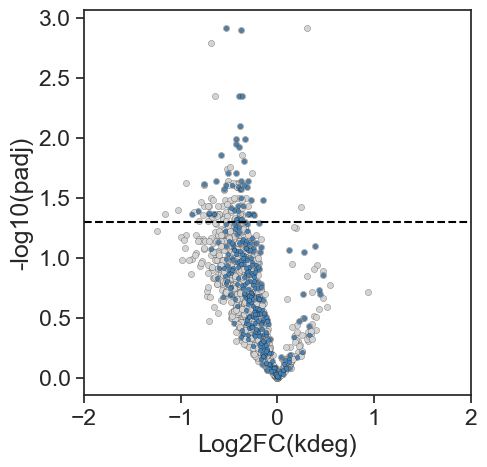

In [42]:
f, ax = plt.subplots(1,1, figsize = (5,5))
long_tails_df = BakR_tails.loc[(BakR_tails.log2FC > 0) & (BakR_tails.FDR < 0.05)]

sns.scatterplot(data = BakR_tails, x = "L2FC_kdeg", y = -np.log10(BakR_tails["padj"]), s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = long_tails_df, x = "L2FC_kdeg", y = -np.log10(long_tails_df["padj"]), s = 10, alpha = 1, color = "steelblue", edgecolor = "black", linewidth = 0.15)

ax.axhline(-np.log10(0.05), color = "black", linestyle = "--")

ax.set_xlim(-2, 2)
ax.set_xlabel("Log2FC(kdeg)")
ax.set_ylabel("-log10(padj)")

plt.savefig(figpath + 'kdeg_4SA_4SD_longerTailColor.png', dpi=300, bbox_inches="tight")

In [43]:
res

NameError: name 'res' is not defined

In [ ]:
BakR_tails.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


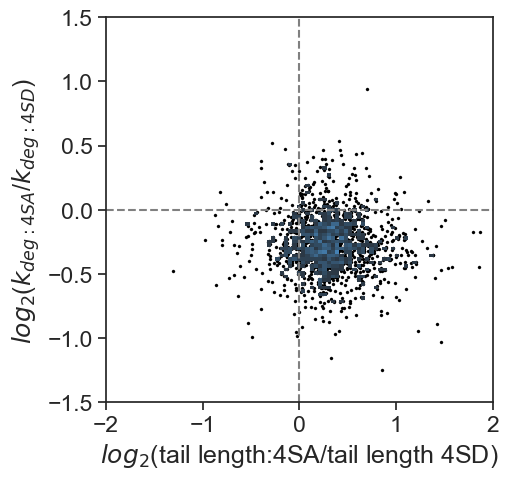

In [44]:
#Correlate ksyn to kdeg
colorway = sns.dark_palette("steelblue", reverse=False, as_cmap=True)


x = BakR_tails.log2FC
y = BakR_tails.L2FC_kdeg
res = stats.linregress(x, y)

f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=x, y=y, s=5, color="black", edgecolor = "black")
sns.histplot(x=x, y=y, bins=80, pthresh=.1, cmap=colorway)

# sns.lineplot(x = x, y = res.intercept + res.slope*x, color = 'grey', linestyle = "--", linewidth = 2)

ax.axhline(0,0, color = "grey", linestyle = "--")
ax.axvline(0,0, color = "grey", linestyle = "--")
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel("$log_{2}$($k_{deg:4SA}$/$k_{deg:4SD}$)")
ax.set_xlabel("$log_{2}$(tail length:4SA/tail length 4SD)")

plt.savefig(figpath + 'tails_v_kdeg_TL_4SAv4SD.png', dpi=300, bbox_inches="tight")

In [45]:
res

LinregressResult(slope=-0.027341403622241543, intercept=-0.25831932293747956, rvalue=-0.04319632274562817, pvalue=0.09954711692501739, stderr=0.01658959039523302, intercept_stderr=0.00785684187206588)

In [ ]:
#Correlate ksyn to kdeg
colorway = sns.dark_palette("steelblue", reverse=False, as_cmap=True)


x = BakR_tails.loc[BakR_tails["gene_name_y"].str.contains("MT")].log2FC
y = BakR_tails.loc[BakR_tails["gene_name_y"].str.contains("MT")].L2FC_kdeg
res = stats.linregress(x, y)

f, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x=x, y=y, s=5, color="black", edgecolor = "black")
sns.histplot(x=x, y=y, bins=80, pthresh=.1, cmap=colorway)

# sns.lineplot(x = x, y = res.intercept + res.slope*x, color = 'grey', linestyle = "--", linewidth = 2)

ax.axhline(0,0, color = "grey", linestyle = "--")
ax.axvline(0,0, color = "grey", linestyle = "--")
ax.set_xlim(-2, 2)
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel("$log_{2}$($k_{deg:4SA}$/$k_{deg:4SD}$)")
ax.set_xlabel("$log_{2}$(tail length:4SA/tail length 4SD)")

# plt.savefig(figpath + 'tails_v_kdeg_TL_4SAv4SD.png', dpi=300, bbox_inches="tight")

In [ ]:
res

In [ ]:
BakR_tails.loc[BakR_tails["gene_name_y"].str.contains("MT")]

In [ ]:
#Add coverage to BakR effects df
nreads = pd.DataFrame(BakR_Fn_estimates_all_mean.groupby("gene_id").nreads.mean())
BakR_effects_df_reads = BakR_effects_df.merge(nreads, on = "gene_id")

In [ ]:
#Make MA plot 
f, ax = plt.subplots(1,1, figsize = (5,5))
sns.scatterplot(data = BakR_effects_df_reads, x = np.log10(BakR_effects_df_reads.nreads), y = "L2FC_kdeg", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = BakR_effects_df_reads.loc[(BakR_effects_df_reads.padj < 0.05) & (BakR_effects_df_reads.L2FC_kdeg < 0)], x = np.log10(BakR_effects_df_reads.loc[(BakR_effects_df_reads.padj < 0.05) & (BakR_effects_df_reads.L2FC_kdeg < 0)].nreads), y = "L2FC_kdeg", s = 20, alpha = 1, color = "steelblue", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = BakR_effects_df_reads.loc[(BakR_effects_df_reads.padj < 0.05) & (BakR_effects_df_reads.L2FC_kdeg > 0)], x = np.log10(BakR_effects_df_reads.loc[(BakR_effects_df_reads.padj < 0.05) & (BakR_effects_df_reads.L2FC_kdeg > 0)].nreads), y = "L2FC_kdeg", s = 20, alpha = 1, color = "orange", edgecolor = "black", linewidth = 0.15)

ax.set_ylim(-2, 2)


ax.set_xlabel("$log_{10}$(Avg. read count)")
ax.set_ylabel("$log_{2}$($k_{deg})$")

plt.savefig(figpath + '4SA_v_4SD_MAplot.png', dpi=300, bbox_inches="tight")

In [ ]:
BakR_effects_df_reads

### GO terms of stabilized genes

In [128]:
GO_component = pd.read_csv("4SA_stabilized_component.txt", skiprows = 11, sep = "\t")
GO_component.columns = ["term", "count_ref", "count_sample", "expected", "over_under", "FC", "pvalue", "padj"]
GO_component["term"] = GO_component.term.str.split("(").str[0]
GO_component["ID"] = "Cellular component"
GO_component = GO_component.sort_values(by = "padj")

GO_bioprocess = pd.read_csv("4SA_stabilized_bioprocess.txt", skiprows = 11, sep = "\t")
GO_bioprocess.columns = ["term", "count_ref", "count_sample", "expected", "over_under", "FC", "pvalue", "padj"]
GO_bioprocess["term"] = GO_bioprocess.term.str.split("(").str[0]
GO_bioprocess["ID"] = "Biological process"
GO_bioprocess = GO_bioprocess.sort_values(by = "padj")
# GO_bioprocess.to_csv("GO_DF.tsv", index = False, sep = "\t")

GO_function = pd.read_csv("4SA_stabilized_mol_function.txt", skiprows = 11, sep = "\t")
GO_function.columns = ["term", "count_ref", "count_sample", "expected", "over_under", "FC", "pvalue", "padj"]
GO_function["term"] = GO_function.term.str.split("(").str[0]
GO_function["ID"] = "Molecular function"
GO_function = GO_function.sort_values(by = "padj")

GO_df = pd.concat([GO_component, GO_bioprocess, GO_function])
GO_df = GO_df.reset_index()

In [5]:
GO_df = pd.read_csv("GO_DF.txt", sep = "\t")
GO_df = GO_df.rename(columns = {"count_sample":"count"})

In [6]:
GO_df 

,term,count_ref,count,expected,over_under,FC,pvalue,padj
0,Deadenylation-dependent RNA decay,25,7,0.93,+,7.51,0.000114,0.0340
1,DNA biosynthetic processes,102,13,3.81,+,3.42,0.000243,0.0489
2,Protein-RNA complex assembly,180,21,6.72,+,3.13,0.000011,0.0118
3,Chromosome organization,230,23,8.58,+,2.68,0.000041,0.0218
4,mRNA metabolic processes,242,23,9.03,+,2.55,0.000139,0.0365
5,Localization to organelles,596,42,22.24,+,1.89,0.000159,0.0390
6,Apoptotic processes,923,60,34.44,+,1.74,0.000045,0.0221


Text(0, 0.5, 'Category')

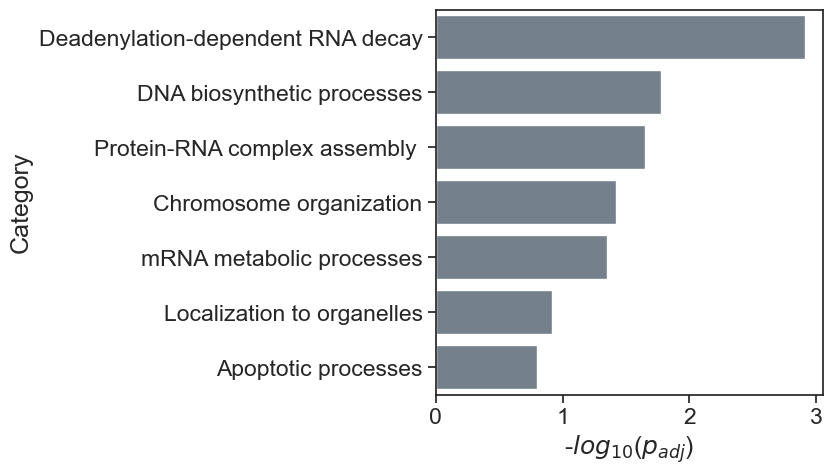

In [13]:
# sns.barplot(GO_df, x = np.log2(GO_df.FC), y = -np.log10(GO_df.padj))
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.barplot(GO_df, y = "term", x = np.log2(GO_df.FC), color = "slategrey")
ax.set_xlabel("-$log_{10}$($p_{adj}$)")
ax.set_ylabel("Category")

# plt.savefig(figpath + 'stabilized_GO_terms.png', dpi=300, bbox_inches="tight")

In [27]:
colorway = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True, reverse = True)

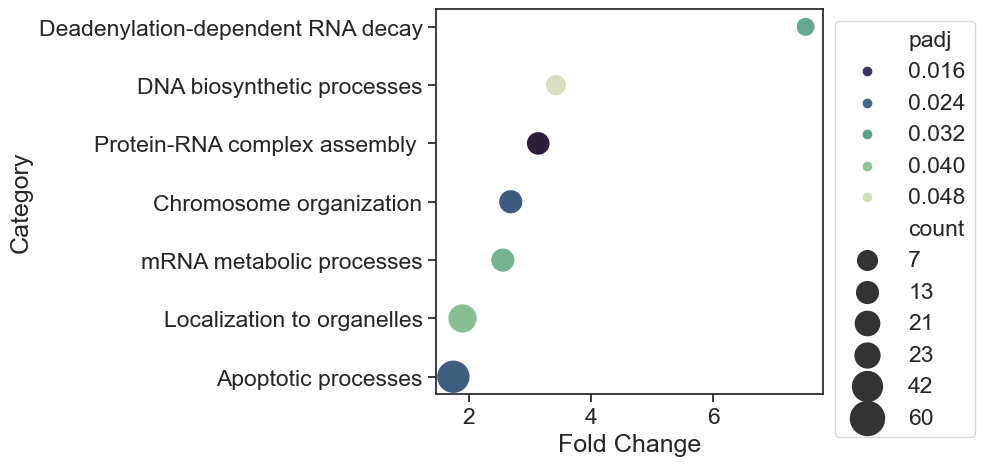

In [28]:
# sns.barplot(GO_df, x = np.log2(GO_df.FC), y = -np.log10(GO_df.padj))
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(GO_df, y = "term", x = GO_df.FC, color = "slategrey", size = "count", sizes=(200, 600), hue = "padj", palette = colorway, alpha = 1)
ax.set_xlabel("Fold Change")
ax.set_ylabel("Category")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(figpath + 'stabilized_GO_terms.png', dpi=300, bbox_inches="tight")